# Figure 4: Do LLMs agree with human judgments?

In [1]:
import yaml
import random
import json
import pandas as pd
import seaborn as sns
import numpy as np
import typing
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib
from matplotlib import pyplot as plt
from functools import reduce

import scipy.stats
from tqdm.auto import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import math
import statsmodels.api as sm
from composlang.utils import get_llm_results, compute_fit, minmax, JointDist

sns.set_theme()


def ECDF_transform(arr: np.ndarray):
    return ECDF(arr)(arr)

### Data-loading function

In [3]:
# ratings = pd.read_csv("./simulate-comb-A-N/beh_stims_9907.csv")
# ratings.sample(1)

,item,item_index,count,rt,age,trial_type,rating,adjective,noun
8305,specified suspicion,5798,12,9024.25,31.75,crit,-0.333333,specified,suspicion


In [2]:
# adj_freq = pd.read_pickle("./simulate-comb-A-N/adj_freqs.pkl")
# noun_freq = pd.read_pickle("./simulate-comb-A-N/noun_freqs.pkl")
# pair_freq = pd.read_pickle("./simulate-comb-A-N/pair_freq.pkl")
# freqs = dict(adj_freq=adj_freq, noun_freq=noun_freq, pair_freq=pair_freq)
adj_p = pd.read_pickle("./simulate-comb-A-N/adj_p.pkl")
noun_p = pd.read_pickle("./simulate-comb-A-N/noun_p.pkl")
pair_p = pd.read_pickle("./simulate-comb-A-N/pair_p.pkl")
joint_p = pd.read_pickle("./simulate-comb-A-N/joint1000.pkl")
freqs = {"adj_p": adj_p, "noun_p": noun_p, "pair_p": pair_p, "joint_p": joint_p}

In [3]:
models = [
    "gpt2_xl",
    "phi_2",
    "mpt_7b",
    "mpt_7b_chat",
    "Mistral_7B_v0.1",
    # "Llama_2_7b_hf",
    # "Llama_2_7b_chat_hf",
    # "Llama_2_70b_chat_hf",
    "mpt_30b",
    "mpt_30b_chat",
]

In [4]:
dfs = {
    model: get_llm_results(
        model=model,
        study="composlang-beh",
        **freqs,
    )
    for model in models
}

** info: could not find logp_A in gpt2_xl x composlang-beh results; skipping
** info: could not find logp_A in gpt2_xl x composlang-beh results; skipping
** info: could not find logp_N in gpt2_xl x composlang-beh results; skipping
** info: could not find logp_A in phi_2 x composlang-beh results; skipping
** info: could not find logp_A in phi_2 x composlang-beh results; skipping
** info: could not find logp_N in phi_2 x composlang-beh results; skipping
** info: could not find likert_constrained_original in phi_2 x composlang-beh results; skipping
** info: could not find likert_constrained_optimized in phi_2 x composlang-beh results; skipping
** info: could not find logp_AN in mpt_7b x composlang-beh results; skipping
** info: could not find logp_AN in mpt_7b_chat x composlang-beh results; skipping
** info: could not find logp_AN in Mistral_7B_v0.1 x composlang-beh results; skipping
** info: could not find likert_constrained_optimized in mpt_30b x composlang-beh results; skipping


In [8]:
mpt30bchat = dfs["mpt_30b_chat"]
mpt30bchat.sample(5)

,adjective,age,bayes_logp_N_A,clogp_A,clogp_AN,clogp_N,count,hybrid_logp_N_A,id,likert_constrained_optimized,likert_constrained_original,logp_A,logp_AN,logp_N,logp_N_A,model,noun,rating,rt,trial_type
6848,pregnant,38.700000,-25.219727,-7.748571,-inf,-10.764226,10,-19.998571,11121,1,5,-12.969727,-33.391602,-13.250000,-12.2500,mpt_30b_chat,predator,4.500000,3898.100000,crit
6239,operational,30.750000,-25.156250,-9.036218,-inf,-11.237764,12,-18.723718,801,1,5,-15.468750,-31.734375,-15.250000,-9.6875,mpt_30b_chat,commercial,3.166667,5146.583333,crit
5867,mutual,24.875000,-26.250000,-8.011240,-inf,-11.424014,8,-21.573740,2869,5,5,-12.687500,-33.218750,-17.859375,-13.5625,mpt_30b_chat,antibody,3.500000,5303.000000,crit
1553,central,30.111111,-25.875000,-6.799014,-inf,-9.433854,9,-19.674014,8351,1,5,-13.000000,-33.687500,-13.750000,-12.8750,mpt_30b_chat,midnight,3.111111,3448.888889,crit
4512,impossible,36.166667,-26.031250,-7.173712,-inf,-9.739269,12,-20.173712,12356,1,5,-13.031250,-33.343750,-10.875000,-13.0000,mpt_30b_chat,migration,5.833333,15548.000000,crit


In [61]:
X_Y_sim = np.zeros((len(adj_freqs), len(noun_freqs)))
X_Y_mpt = np.zeros((len(adj_freqs), len(noun_freqs)))
adj_ix = {}
noun_ix = {}

for i, row in mpt30bchat.iterrows():
    # print(i, row)
    adj = row[("metadata", "adjective")]
    noun = row[("metadata", "noun")]
    if adj in adj_ix:
        aix = adj_ix[adj]
    else:
        adj_ix[adj] = (aix := len(adj_ix))
    if noun in noun_ix:
        nix = noun_ix[noun]
    else:
        noun_ix[noun] = (nix := len(noun_ix))

    X_Y_sim[aix, nix] = row[("metadata", "adj_freq")] * row[("metadata", "noun_freq")]
    X_Y_mpt[aix, nix] = row[("model", "logp_N_A")]

In [73]:
E_X_Y_sim = entropy(X_Y_sim.reshape(-1))
E_X_Y_sim_ = entropy(np.outer(adj_freqs, noun_freqs).reshape(-1))
E_X_Y_hum = entropy(ratings)
E_X_Y_mpt = entropy(minmax(mpt30bchat["model", "logp_N_A"]))
E_X_Y_mpt_ = entropy(X_Y_mpt.reshape(-1))

In [77]:
I_X_Y_sim = E_X + E_Y - E_X_Y_sim
I_X_Y_sim_ = E_X + E_Y - E_X_Y_sim_
I_X_Y_hum = E_X + E_Y - E_X_Y_hum
I_X_Y_mpt = E_X + E_Y - E_X_Y_mpt
I_X_Y_mpt_ = E_X + E_Y - E_X_Y_mpt_

print(f"{E_X=:.3f}, {E_Y=:.3f}")
print()
print(f"{E_X_Y_sim=:.3f}  {I_X_Y_sim=:.3f}")
print(f"{E_X_Y_sim_=:.3f} {I_X_Y_sim_=:.3f}")
print()
print(f"{E_X_Y_hum=:.3f}  {I_X_Y_hum=:.3f}")
print()
print(f"{E_X_Y_mpt=:.3f}  {I_X_Y_mpt=:.3f}")
print(f"{E_X_Y_mpt_=:.3f} {I_X_Y_mpt_=:.3f}")

E_X=5.839, E_Y=7.278

E_X_Y_sim=7.866  I_X_Y_sim=5.251
E_X_Y_sim_=13.117 I_X_Y_sim_=-0.000

E_X_Y_hum=9.055  I_X_Y_hum=4.062

E_X_Y_mpt=9.185  I_X_Y_mpt=3.932
E_X_Y_mpt_=9.188 I_X_Y_mpt_=3.929


In [11]:
# def mean_keep_strings(series):
#     if series.dtype == object:
#         return series.iloc[0]
#     else:
#         return series.mean()


# llm_agg = (
#     pd.concat(
#         [mpt7b, mpt30b, mpt_30b_chat, mpt7bchat, gpt2xl, mistral7b],
#     )
#     .groupby([("metadata", "id")])
#     .agg(mean_keep_strings)
# )
# llm_agg["metadata", "model"] = " ".join(models)
# llm_agg.sample(3)

### Predict human ratings with LLMs

Text(0, 0.5, 'MPT-30B $\\;\\log P(N|A)$')

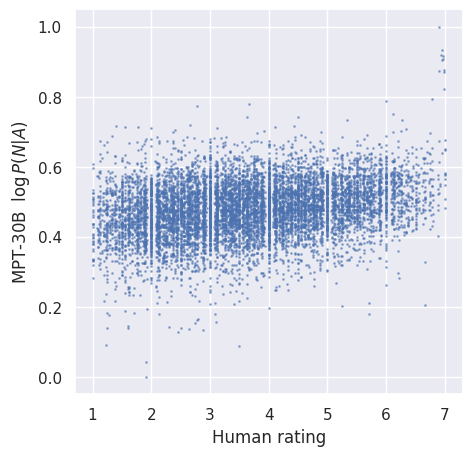

In [30]:
mpt30b = dfs["mpt_30b"]
f, ax = plt.subplots(figsize=(5, 5))
ax.scatter(
    mpt30b["rating"],
    minmax(mpt30b["logp_N_A"]),
    s=1,
    alpha=0.5,
    edgecolor=None,
    # c=mpt30b["clogp_A"],
)
ax.set_xlabel("Human rating")
ax.set_ylabel("MPT-30B $\;\log P(N|A)$")

In [ ]:
def compute_corrs(x, y, model_name):
    from scipy.stats import spearmanr, pearsonr

    pearsonr = scipy.stats.pearsonr(x, y)
    spearmanr = scipy.stats.spearmanr(x, y)

    result = {
        "model": model_name,
        "pearsonr": pearsonr.statistic,
        "pearsonr_p": pearsonr.pvalue,
        "pearsonr_ci": pearsonr.confidence_interval(0.95),
        "spearmanr": spearmanr.correlation,
        "spearmanr_p": spearmanr.pvalue,
        # "spearmanr_ci": spearmanr.confidence_interval(0.95),
    }
    return result

In [21]:
spearmanr(mpt30b["logp_N_A"], mpt30b["rating"])

SpearmanrResult(correlation=0.2582334198826436, pvalue=1.141351334043218e-150)

                            OLS Regression Results                            
Dep. Variable:               logp_N_A   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     666.4
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          2.85e-142
Time:                        04:56:53   Log-Likelihood:                -19739.
No. Observations:                9907   AIC:                         3.948e+04
Df Residuals:                    9905   BIC:                         3.950e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.9624      0.021   -611.534      0.0

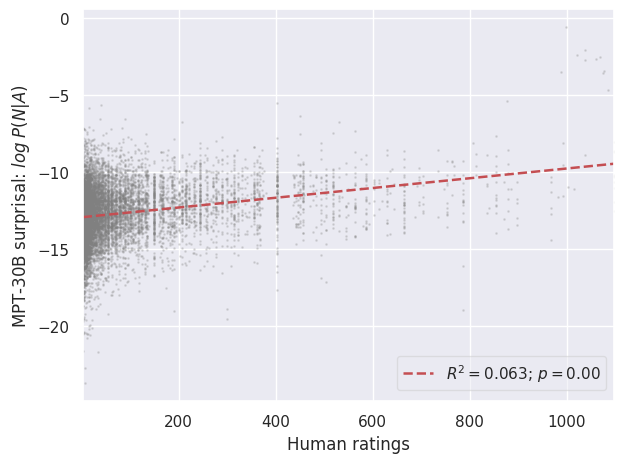

In [10]:
x, y, fit = compute_fit(
    dfs["mpt_30b"],
    # "clogp_A*N",
    "logp_N_A",
    target="rating",
    logy=False,
    flip=True,
    expx=False,
    expy=True,
    normy=False,
    normx=False,
)
print(fit.summary())


f, ax = plt.subplots(
    # figsize=(7, 5)
)
ax.scatter(x, y, alpha=0.2, s=1, c="gray")
# ax.set_yscale("log")
# ax.set_yscale("log")
# extract intercept b and slope m
b, m = fit.params
# plot y = m*x + b
ax.axline(
    xy1=(0, b),
    xy2=(1, m + b),
    color="r",
    linewidth=1.8,
    linestyle="--",
    # slope=m,
    # label=f"$y = {m:.1f}x {b:+.1f}$; $R^2={fit.rsquared:.3f}$; $p={fit.pvalues[1]:.2f}$",
    label=f"$R^2={fit.rsquared:.3f}$; $p={fit.pvalues[1]:.2f}$",
)
ax.set_xlim(min(x) - 0.2, max(x) + 0.2)
# ax.set_ylim(1e-0, max(y) + 1)
ax.legend(loc="lower right", bbox_to_anchor=(1, 0.01), framealpha=0.5)
# ax.set_title( "MPT-30B against human ratings of $\\approx10k$ unattested Adjective-Noun pairs")
# ax.set_ylabel("mpt-30B $\quad$ normalized $[log\; P(N|A)]$")
ax.set_xlabel("Human ratings")
ax.set_ylabel("MPT-30B surprisal: $log\;P(N|A)$")

plt.tight_layout()
plt.show()

In [13]:
# def compute_fit_(data, target="rating", metric="logp_N_A"):
#     y = data["metadata", target]
#     x = data["model", metric]
#     model = sm.OLS(y, sm.add_constant(x))
#     fit = model.fit()

#     return fit, dict(
#         b=fit.params[0], m=fit.params[1], p=fit.pvalues[1], r2=fit.rsquared
#     )


# def plot_fit(data, metric="logp_N_A"):
#     model_name = data["metadata", "model"].iloc[0]

#     fit, info = compute_fit(data, metric=metric)
#     b, m = fit.params
#     print(fit.summary())
#     f, ax = plt.subplots(figsize=(7, 5))

#     y = data["metadata", "rating"]
#     x = data["model", metric]
#     ax.scatter(x, y, alpha=0.5, s=1)
#     # ax.set_yscale("log")
#     # ax.set_yscale("log")
#     # extract intercept b and slope m
#     # plot y = m*x + b
#     ax.axline(
#         xy1=(0, b),
#         # xy2=(10, 10 * m + b),
#         color="r",
#         linewidth=2,
#         linestyle="-",
#         slope=m,
#         label=f"$y = {m:.1f}x {b:+.1f}$; $R^2={fit.rsquared:.3f}$; $p={fit.pvalues[1]:.2f}$",
#     )
#     # ax.set_xlim(min(x), max(x))
#     # ax.set_ylim(1, max(y))
#     ax.legend(loc="lower right", bbox_to_anchor=(1, 0))
#     ax.set_title(f"{model_name} {metric} predict human ratings")
#     ax.set_xlabel(model_name + " " + metric)
#     ax.set_ylabel("human ratings")

#     plt.tight_layout()
#     plt.show()

#     return fit.rsquared, fit.pvalues.tolist()[1]

In [46]:
dfs.keys()

dict_keys(['gpt2_xl', 'phi_2', 'mpt_7b', 'mpt_7b_chat', 'Mistral_7B_v0.1', 'Llama_2_7b_hf', 'Llama_2_7b_chat_hf', 'Llama_2_70b_chat_hf', 'mpt_30b', 'mpt_30b_chat'])

In [9]:
# compare model fits to human data
all_models = []
for model_name in dfs:
    if "Llama" in model_name:
        continue
    x, y, fit = compute_fit(
        dfs[model_name],
        "hybrid_logp_N_A",
        target="rating",
        logy=False,
        # flip=True,
        expy=True,
        # exp=False,
        # normy=True,
        # normx=True,
    )
    r2, p = fit.rsquared, fit.pvalues.tolist()[1]
    err = fit.bse.tolist()[1]
    print(f"{model_name=} {r2=:.3f} {p=:.3f} {err=:.3f}")

    all_models.append(dict(model=model_name, r2=r2, p=p, std=err))

model_name='gpt2_xl' r2=0.016 p=0.000 err=177888.288
model_name='phi_2' r2=0.017 p=0.000 err=174721.003
model_name='mpt_7b' r2=0.027 p=0.000 err=303258.921
model_name='mpt_7b_chat' r2=0.020 p=0.000 err=163456.382
model_name='Mistral_7B_v0.1' r2=0.020 p=0.000 err=171386.107
model_name='mpt_30b' r2=0.031 p=0.000 err=323745.612
model_name='mpt_30b_chat' r2=0.025 p=0.000 err=242068.165


In [8]:
for metric in ["clogp_A", "clogp_N", "clogp_A*N"]:
    *_, fit = compute_fit(
        dfs["gpt2_xl"],
        metric=metric,
        target="rating",
        # exp=True,
        logy=False,
        normx=True,
    )
    print(
        f"{metric} {fit.rsquared=:.4f}, {fit.pvalues.to_list()[1]=:.3f}; eqn: y = {fit.params.to_list()[1]:.3f}x + {fit.params.to_list()[0]:.3f}"
    )
    # record std error
    std = fit.bse.tolist()[1]
    # record ci
    # ci = fit.conf_int()[0][1], fit.conf_int()[1][1]
    all_models.append(
        {
            "model": metric,
            "r2": fit.rsquared,
            "p": fit.pvalues.to_list()[1],
            "std": std,
            # "ci1": ci[0],
            # "ci2": ci[1],
        }
    )

clogp_A fit.rsquared=0.0000, fit.pvalues.to_list()[1]=0.511; eqn: y = 0.076x + 3.597
clogp_N fit.rsquared=0.0001, fit.pvalues.to_list()[1]=0.302; eqn: y = -0.159x + 3.706
clogp_A*N fit.rsquared=0.0001, fit.pvalues.to_list()[1]=0.465; eqn: y = -0.083x + 3.674


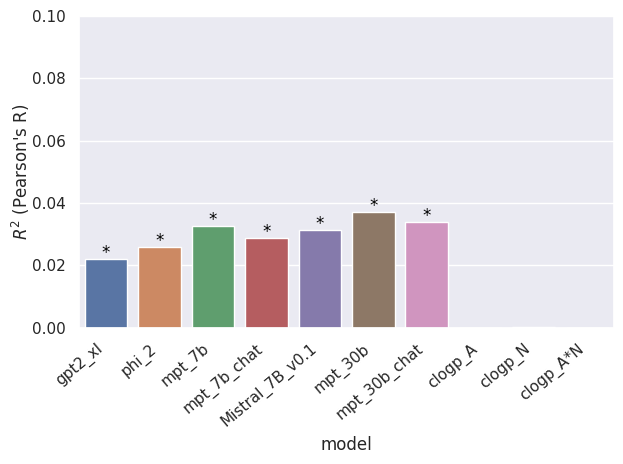

In [18]:
all_models = pd.DataFrame(all_models)

ax = sns.barplot(
    x=all_models["model"],
    y=all_models["r2"],
)
# ax.set_xlim(0, 0.1)
# rotate xaxis labels
plt.xticks(rotation=40, ha="right")
# plt.title(
#     "Observed frequency in COCA vs.\nModel predictions scaled to model marginals: $P_{model}(N|A)P_{model}(A)$"
# )
# plt.title("Human ratings about sensibility on a Likert scale vs. Model predictions")
plt.ylabel("$R^2$ (Pearson's R)", rotation=90, labelpad=0.1)
# plt.xlabel("Model")

# place asterisk marking significance above each bar
for i, row in all_models.iterrows():
    ax.text(
        i,
        row["r2"] - 0.001,
        "*" if row["p"] < 0.05 else "",
        ha="center",
        va="bottom",
        color="black",
    )
# plot error bars
# ax.errorbar(
#     x=all_models.index,
#     y=all_models["r2"],
#     yerr=all_models["std"],
#     fmt="none",
#     c="black",
#     capsize=5,
# )
ax.set_ylim(0, 0.1)

plt.tight_layout()
plt.show()

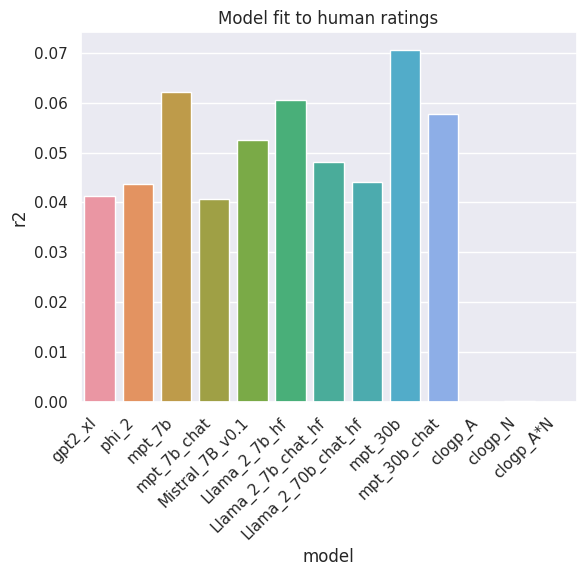

In [77]:
sns.barplot(data=pd.DataFrame(all_models), x="model", y="r2")
# rotate x labels
plt.title("Model fit to human ratings")
plt.xticks(rotation=45, ha="right")
plt.show()